In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
#import esmvalcore.preprocessor as ecpr
#import pymannkendall as mkt
import pandas as pd

%matplotlib inline

/tmp/ipykernel_2286/261797937.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

# there is currently a significant amount of data for these runs
expts_full = ['historical','ssp126', 'ssp245', 'ssp370', 'ssp585', 'piControl']

query = dict(
    #activity_id = 'DAMIP',
    experiment_id=expts_full,
    table_id='Amon',                           
    variable_id=['tas', 'pr', 'ua', 'va'],
    member_id = 'r1i1p1f1',                     
)

col_subset = col.search(require_all_on='source_id', **query)
#col_subset.df = col_subset.df[col_subset.df['source_id'] != 'FGOALS-f3-L']
col_subset_var = [col_subset.search(variable_id=var_name) for var_name in query['variable_id']]
print(f'Number of models found: {col_subset.df.source_id.nunique()}')

Number of models found: 25


In [3]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    #assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True, decode_times=True, use_cftime=True)
    if 'plev' in ds.coords:
        for lev in ds.plev.values:
            if int(lev)==85000:
                ind = np.where(ds.plev.values==lev)
                break
        ds = ds.isel(plev=ind[0]).drop('plev')
        #ds.drop('plev')
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = []
for col_subset in col_subset_var :
    dset = defaultdict(dict)

    for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
        dset[group[0]][group[1]] = open_delayed(df)
    dsets.append(dset)
len(dsets)

4

In [4]:
with progress.ProgressBar():
    dsets_ = [dask.compute(dict(dset))[0] for dset in dsets]

[########################################] | 100% Completed | 19.7s
[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed | 20.8s
[########################################] | 100% Completed | 20.6s


In [105]:
import pymannkendall as mkt
import esmvalcore.preprocessor as ecpr
import dask.array as da
import iris
import itertools
import xesmf as xe

def get_vname(ds):
    #print(ds.variables)
    for v_name in ds.variables.keys():
        #print(v_name)
        if v_name in ['pr', 'ua', 'va']:
            return v_name
    raise RuntimeError("Couldn't find a variable")
            
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")
    
def get_lon_name(ds):
    for lon_name in ['lon', 'longitude']:
        if lon_name in ds.coords:
            return lon_name
    raise RuntimeError("Couldn't find a longitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

def time_correction(ds):
    ds_last = ds.groupby('time.year').mean().isel(year=np.arange(-100,0)[::-1])
    ds_last = ds_last.assign_coords({'year_num': ('year',np.arange(1,101))}).swap_dims({'year':'year_num'}).drop('year')
    ds_last = ds_last.rename({'year_num':'year'})
    return ds_last

In [106]:
from toolz.functoolz import juxt
expts = expts_full[-1]
#expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
#                       coords={'experiment_id': expts})

dsets_aligned_list = []
for dset_ in dsets_[:2]:
    j=0
    dsets_aligned = {}
    for k, v in tqdm(dset_.items()):
        
        expt_dsets = v.values()
        if any([d is None for d in expt_dsets]):
            print(f"Missing experiment for {k}")
            continue

    
        # workaround for
        # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
        dsets_ann_mean = v[expts].pipe(global_mean).pipe(time_correction)

        # align everything with the 4xCO2 experiment

        dsets_aligned[k] = dsets_ann_mean
        
    dsets_aligned_list.append(dsets_aligned)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [107]:
with progress.ProgressBar():
    dsets_aligned_list_1 = dask.compute(dsets_aligned_list[0])[0]
    
with progress.ProgressBar():
    dsets_aligned_list_2 = dask.compute(dsets_aligned_list[1])[0]
    
dsets_algned_list_ = [dsets_aligned_list_1, dsets_aligned_list_2]

[########################################] | 100% Completed | 20.1s
[########################################] | 100% Completed | 23.4s


In [108]:
source_ids = [list(dsets_aligned_.keys()) for dsets_aligned_ in dsets_algned_list_]

big_ds = []
for idx, dsets_aligned_ in enumerate(dsets_algned_list_):
    source_da = xr.DataArray(source_ids[idx], dims='source_id', name='source_id',
                         coords={'source_id': source_ids[idx]})
    big_ds.append(xr.concat([ds.reset_coords(drop=True)
                        for ds in dsets_aligned_.values()],
                        dim=source_da))


In [109]:
ds_all = big_ds[0].assign(pr=big_ds[1].pr)

In [118]:
ds_all = ds_all.isel(year=np.arange(50))

# Timeseries

In [119]:
ds_hist = xr.open_dataset('/home/jovyan/pangeo/data/tas_pr_global_timeseries.nc')
small_ds = ds_hist.sel(year=slice(1950, 2100)).rolling(year=2).mean()

In [120]:
cl_t0, cl_tf = 1984, 2014
clim_ds = ds_hist.sel(experiment_id='historical', year=slice(cl_t0, cl_tf)).mean(dim=('year')) 

dev_ds_pipr = ((ds_all.pr - clim_ds.pr)/clim_ds.pr)*100 
dev_ds_pitas = ds_all.tas - clim_ds.tas

dev_ds_pr = ((small_ds.pr - clim_ds.pr)/clim_ds.pr)*100 
dev_ds_tas = small_ds.tas - clim_ds.tas

In [121]:
ens_ds_pipr = dev_ds_pipr.mean(dim='source_id')
print(ens_ds_pipr.shape)

ens_ds_pitas = dev_ds_pitas.mean(dim='source_id')
print(ens_ds_pitas.shape)


ens_ds_pr = dev_ds_pr.mean(dim='source_id')
print(ens_ds_pr.shape)

ens_ds_tas = dev_ds_tas.mean(dim='source_id')
ens_ds_tas.shape

(50,)
(50,)
(5, 151)


(5, 151)

In [122]:
dev_ds_pr.shape

(25, 5, 151)

In [ ]:
import itertools as it
spread_max_pipr = np.empty(shape=ens_ds_pitas.shape)
spread_min_pipr = np.empty_like(spread_max_pipr)

spread_max_pitas = np.empty_like(spread_max_pipr)
spread_min_pitas = np.empty_like(spread_max_pipr)

for i in range(50):  ##instead of nested for loops. works same.
    spread_max_pipr[i] = np.nanmax(dev_ds_pipr[:, i]-ens_ds_pipr[i])
    spread_min_pipr[i] = np.nanmin(dev_ds_pipr[:, i]-ens_ds_pipr[i])
    
    spread_max_pitas[i] = np.nanmax(dev_ds_pitas[:, i]-ens_ds_pitas[i])
    spread_min_pitas[i] = np.nanmin(dev_ds_pitas[:, i]-ens_ds_pitas[i])

spread_pitas ={'max_vals' : spread_max_pitas, 
             'min_vals' : spread_min_pitas}

spread_pipr ={'max_vals' : spread_max_pipr, 
             'min_vals' : spread_min_pipr}

spr_pi = [spread_pitas, spread_pipr]


spread_max_pr = np.empty(shape=(5, 151))
spread_min_pr = np.empty(shape=(5, 151))

spread_max_tas = np.empty(shape=(5, 151))
spread_min_tas = np.empty(shape=(5, 151))

for i,j in it.product(range(5), range(151)):  ##instead of nested for loops. works same.
    spread_max_pr[i, j] = np.nanmax(dev_ds_pr[:, i, j]-ens_ds_pr[i, j])
    spread_min_pr[i, j] = np.nanmin(dev_ds_pr[:, i, j]-ens_ds_pr[i, j])
    
    spread_max_tas[i, j] = np.nanmax(dev_ds_tas[:, i, j]-ens_ds_tas[i, j])
    spread_min_tas[i, j] = np.nanmin(dev_ds_tas[:, i, j]-ens_ds_tas[i, j])

spread_tas ={'max_vals' : spread_max_tas, 
             'min_vals' : spread_min_tas}

spread_pr ={'max_vals' : spread_max_pr, 
             'min_vals' : spread_min_pr}

spr = [spread_tas, spread_pr]

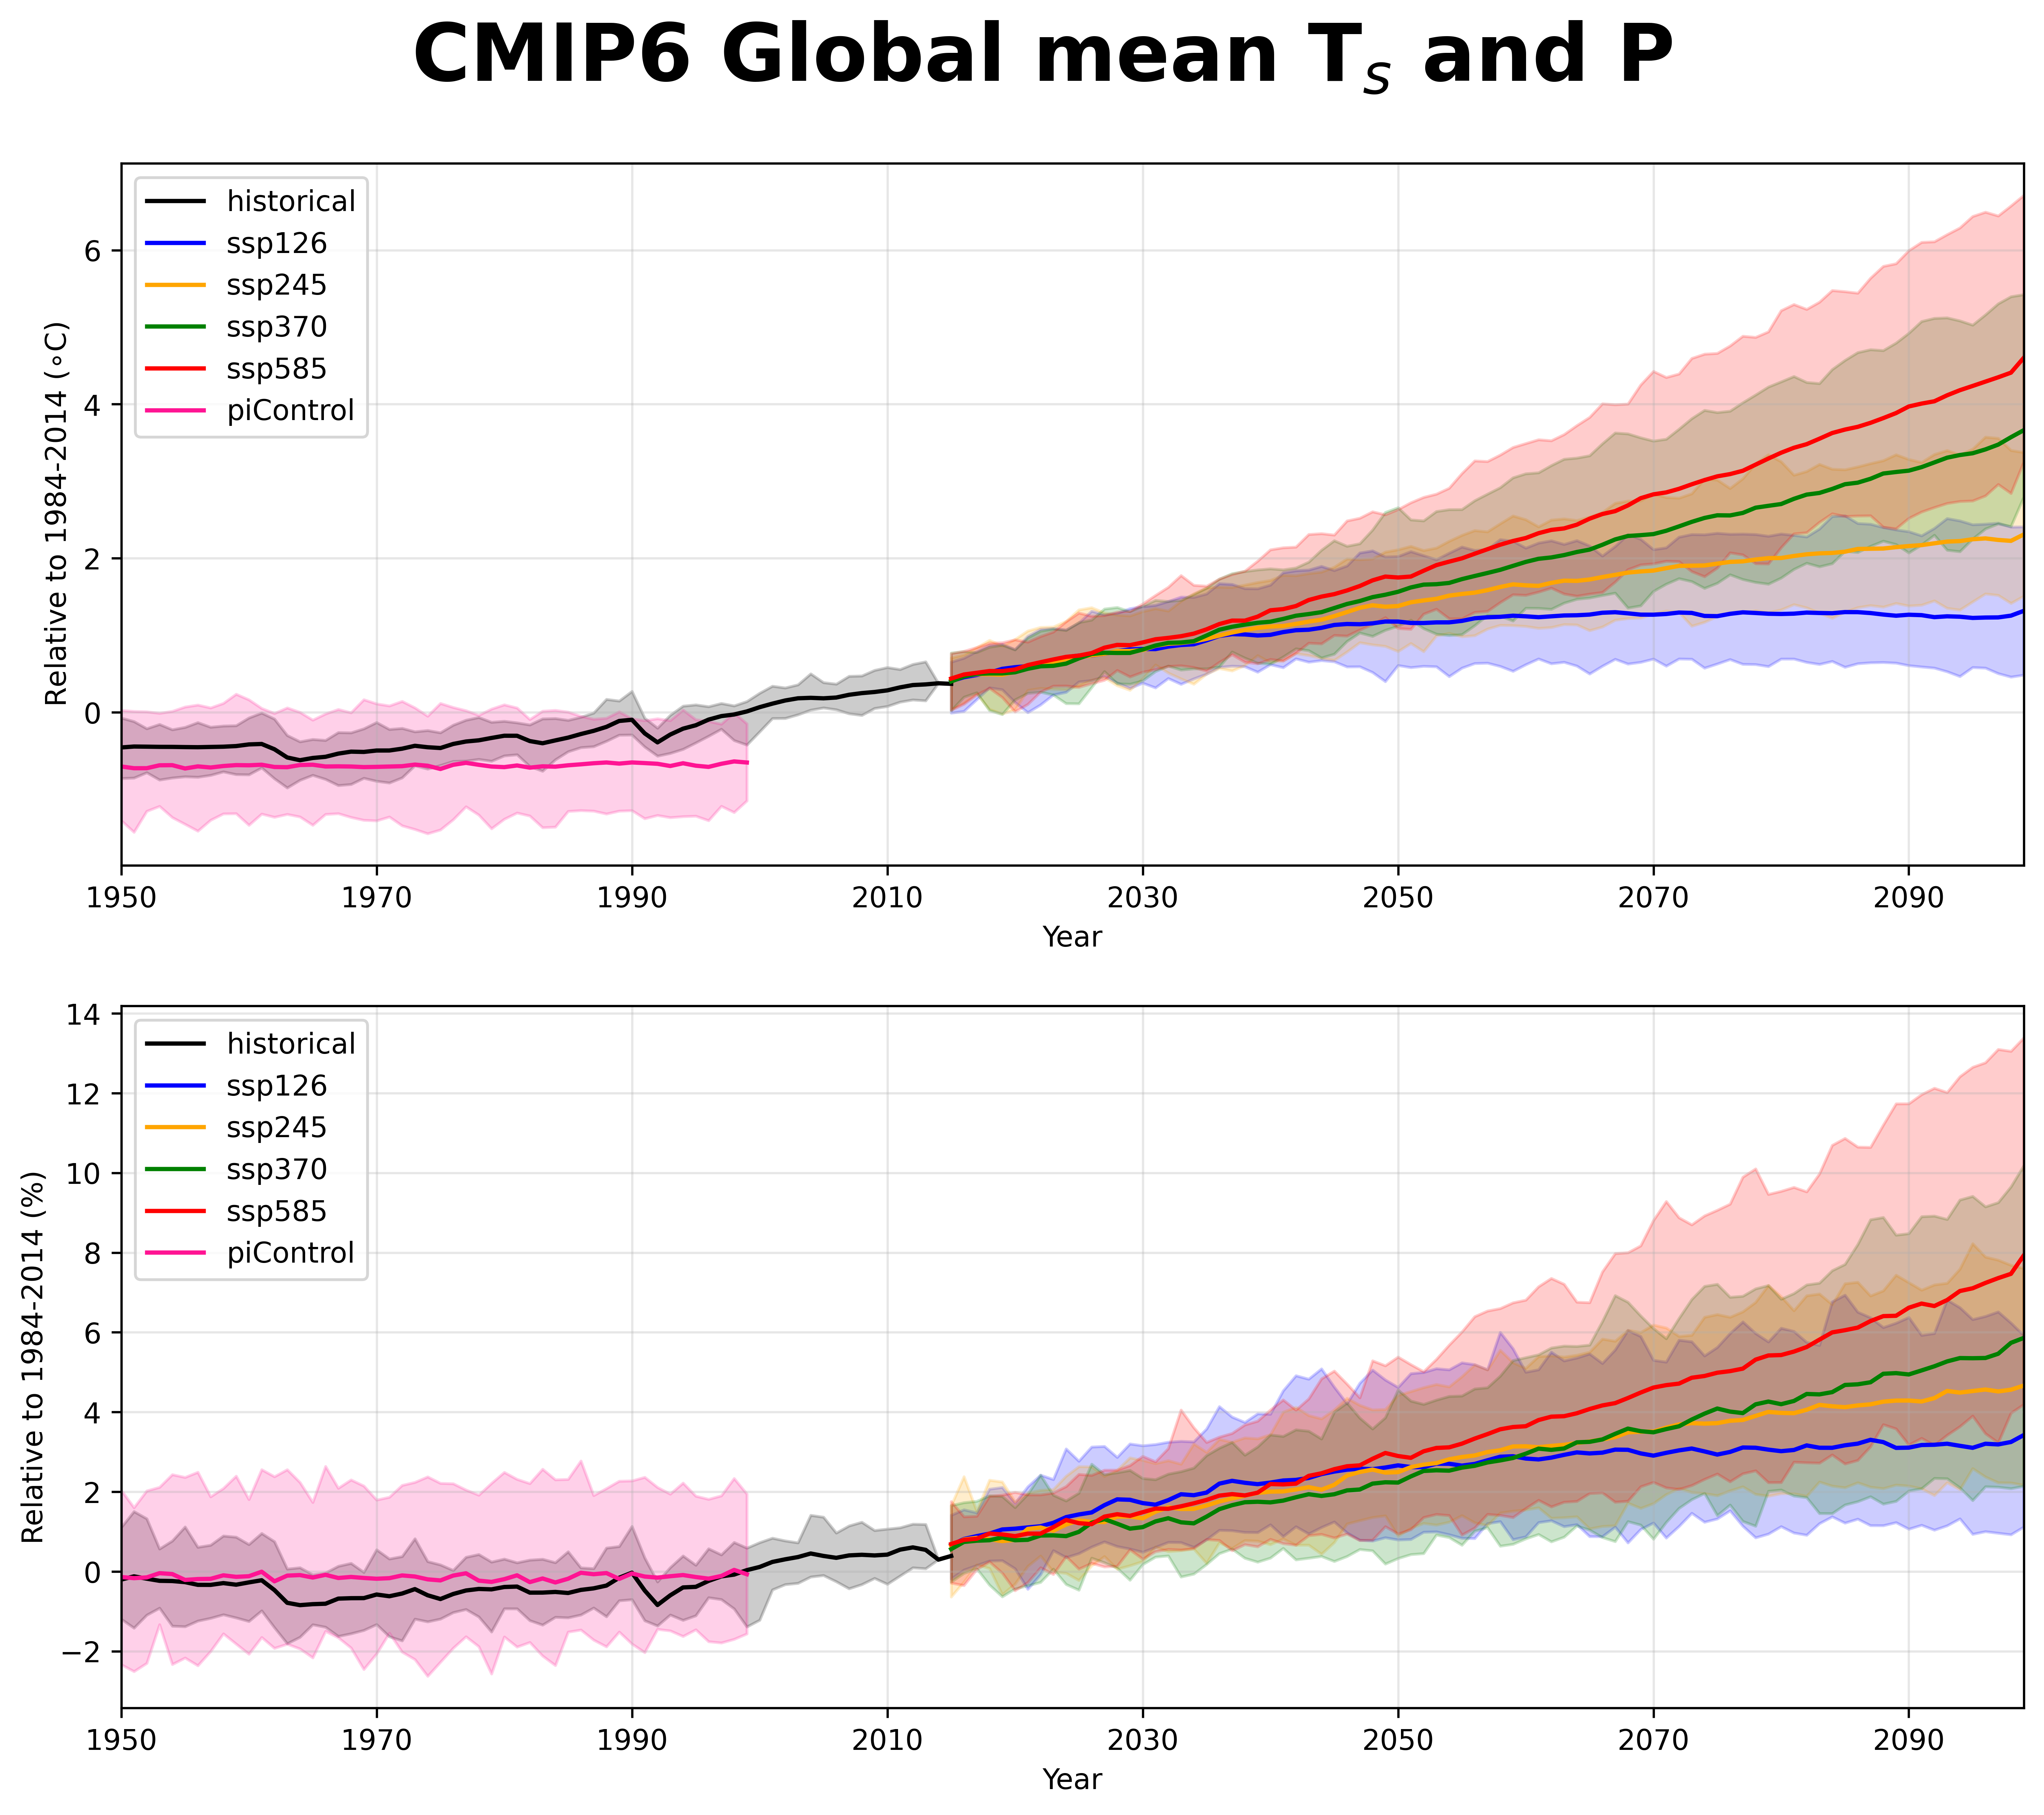

In [126]:
from matplotlib import cm
import matplotlib.colors as mcl
cmap = cm.turbo
#cl = ['k']+[mcl.rgb2hex(cmap(i)[:20]) for i in range(0,cmap.N,50)]
#print(cl)
cl = ['k'] + ['blue', 'orange', 'green','red', 'deeppink']

ncols, nrows = 1, 2
fig, axs = plt.subplots(nrows, ncols, dpi=600, figsize = (12,10))

ens_dss_pi = [ens_ds_pitas, ens_ds_pipr]
ens_dss = [ens_ds_tas, ens_ds_pr]

y_l = [f'Relative to {cl_t0}-{cl_tf} ($\circ$C)', 
       f'Relative to {cl_t0}-{cl_tf} (%)']

for i in range(nrows):
        ax = axs[i]
        ens_pi = ens_dss_pi[i]
        ens_ds = ens_dss[i]
        
        for j in range(6):
            #print(j)
            if j != 5:
                data = ens_ds.isel(experiment_id=j)
                #print(data.shape, (data.values+spr[i]['max_vals'][j, :]).shape)
                ax.plot(data.values, c=cl[j], label = data.experiment_id.values)
                ax.fill_between(np.arange(151), data.values+spr[i]['max_vals'][j, :], 
                                 data.values+spr[i]['min_vals'][j,:], alpha=0.2, color=cl[j] )
                
            else:
                datapi = ens_pi
                ax.plot(datapi.year, datapi.values, c=cl[j], label = 'piControl')
                ax.fill_between(datapi.year, datapi.values+spr_pi[i]['max_vals'], 
                                 datapi.values+spr_pi[i]['min_vals'], alpha=0.2, color=cl[j] )
                

        ax.set_xlabel('Year')
        ax.set_ylabel(y_l[i])
        ax.set_xticks(np.arange(1,151,20))
        ax.set_xticklabels(np.arange(1950, 2100,20))
        ax.set_xlim(1,150)
        ax.legend(loc='upper left')
        ax.grid(alpha=0.3)

fig.suptitle('CMIP6 Global mean T$_s$ and P', x=0.5, y =0.95, fontsize=28, weight='bold')
plt.savefig('/home/jovyan/pangeo/plot/global_average_picontrol.png', bbox_inches='tight', facecolor='w')

In [70]:
spr[i]['max_vals'][4, :].shape

(151,)